In [1]:
import cv2
import math
import tensorflow as tf
import numpy as np
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def solve_image():
    batch_images = []
    for i in range(1, 11):
        imgFile = './GAN/' + str(i) + '.jpg'
        # load an original image
        img = cv2.imread(imgFile)
        # color value range
        cRange = 256
        rows,cols,channels = img.shape
        # convert color space from bgr to gray
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (56, 56))
        imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
        # otsu method
        threshold,imgOtsu = cv2.threshold(imgGray,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        from PIL import Image
        new_im = Image.fromarray(imgOtsu.astype(np.uint8))
#         new_im.show()
        new_im.save('./solved_GAN/' + str(i) + '.jpg')
        # 将图片拉伸至一维
        batch_images.append(imgOtsu.reshape((1, 56*56)))
    return batch_images

In [3]:
images = solve_image()

In [4]:
images[0].shape

(1, 3136)

In [5]:
def get_inputs(real_size, noise_size):
    """
    真实图像tensor与噪声图像tensor
    """
    real_img = tf.placeholder(tf.float32, [None, real_size], name='real_img')
    noise_img = tf.placeholder(tf.float32, [None, noise_size], name='noise_img')
    
    return real_img, noise_img

In [6]:
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
    """
    生成器
    
    noise_img: 生成器的输入
    n_units: 隐层单元个数
    out_dim: 生成器输出tensor的size，这里应该为56*56=3136
    alpha: leaky ReLU系数
    """
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)

        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

In [7]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    """
    判别器
    
    n_units: 隐层结点数量
    alpha: Leaky ReLU系数
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

In [8]:
# 定义参数
# 真实图像的size
img_size = 56 * 56
# 传入给generator的噪声size
noise_size = 100
# 生成器隐层参数
g_units = 1280
# 判别器隐层参数
d_units = 1280
# leaky ReLU的参数
alpha = 0.01
# learning_rate
learning_rate = 0.001
# label smoothing
smooth = 0.1

In [9]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)

# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.


In [10]:
# discriminator的loss
# 识别真实图片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)) * (1 - smooth))
# 识别生成的图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_fake)))
# 总体loss
d_loss = tf.add(d_loss_real, d_loss_fake)

# generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)) * (1 - smooth))

In [11]:
train_vars = tf.trainable_variables()

# generator中的tensor
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator中的tensor
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

In [12]:
# batch_size
batch_size = 1
# 训练迭代轮数
epochs = 230
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []
# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)
# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(10):
            
            batch_images = images[batch_i]
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, 
                                     feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, 
                                    feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # 记录各类loss值
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 抽取样本后期进行观察
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        # 存储checkpoints
        saver.save(sess, './checkpoints/generator.ckpt')

# 将sample的生成数据记录下来
with open('train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Epoch 1/230... Discriminator Loss: 49.5744(Real: 0.0000 + Fake: 49.5744)... Generator Loss: 0.0000
Epoch 2/230... Discriminator Loss: 42.6921(Real: 0.0000 + Fake: 42.6921)... Generator Loss: 0.0000
Epoch 3/230... Discriminator Loss: 35.8489(Real: 0.0000 + Fake: 35.8489)... Generator Loss: 0.0000
Epoch 4/230... Discriminator Loss: 0.0285(Real: 0.0000 + Fake: 0.0285)... Generator Loss: 3.2140
Epoch 5/230... Discriminator Loss: 55.3699(Real: 0.0000 + Fake: 55.3699)... Generator Loss: 0.0000
Epoch 6/230... Discriminator Loss: 82.8132(Real: 0.0000 + Fake: 82.8132)... Generator Loss: 0.0000
Epoch 7/230... Discriminator Loss: 54.6275(Real: 0.0000 + Fake: 54.6275)... Generator Loss: 0.0000
Epoch 8/230... Discriminator Loss: 55.2478(Real: 0.0000 + Fake: 55.2478)... Generator Loss: 0.0000
Epoch 9/230... Discriminator Loss: 42.2250(Real: 0.0000 + Fake: 42.2250)... Generator Loss: 0.0000
Epoch 10/230... Discriminator Loss: 32.1500(Real: 0.0000 + Fake: 32.1500)... Generator Loss: 0.0000
Epoch 11/23

Epoch 82/230... Discriminator Loss: 702.9490(Real: 0.0000 + Fake: 702.9490)... Generator Loss: 0.0000
Epoch 83/230... Discriminator Loss: 427.2992(Real: 0.0000 + Fake: 427.2992)... Generator Loss: 0.0000
Epoch 84/230... Discriminator Loss: 218.0969(Real: 0.0000 + Fake: 218.0969)... Generator Loss: 0.0000
Epoch 85/230... Discriminator Loss: 87.9249(Real: 0.0000 + Fake: 87.9249)... Generator Loss: 0.0000
Epoch 86/230... Discriminator Loss: 19.0685(Real: 0.0000 + Fake: 19.0685)... Generator Loss: 0.0000
Epoch 87/230... Discriminator Loss: 120.9282(Real: 0.0000 + Fake: 120.9282)... Generator Loss: 0.0000
Epoch 88/230... Discriminator Loss: 0.0000(Real: 0.0000 + Fake: 0.0000)... Generator Loss: 75.3867
Epoch 89/230... Discriminator Loss: 0.0000(Real: 0.0000 + Fake: 0.0000)... Generator Loss: 29.3532
Epoch 90/230... Discriminator Loss: 0.0000(Real: 0.0000 + Fake: 0.0000)... Generator Loss: 23.5994
Epoch 91/230... Discriminator Loss: 0.0000(Real: 0.0000 + Fake: 0.0000)... Generator Loss: 15.5

Epoch 163/230... Discriminator Loss: 0.0000(Real: 0.0000 + Fake: 0.0000)... Generator Loss: 36.4813
Epoch 164/230... Discriminator Loss: 40.1352(Real: 0.0000 + Fake: 40.1352)... Generator Loss: 0.0000
Epoch 165/230... Discriminator Loss: 918.2288(Real: 0.0000 + Fake: 918.2288)... Generator Loss: 0.0000
Epoch 166/230... Discriminator Loss: 1704.0219(Real: 0.0000 + Fake: 1704.0219)... Generator Loss: 0.0000
Epoch 167/230... Discriminator Loss: 1868.7429(Real: 0.0000 + Fake: 1868.7429)... Generator Loss: 0.0000
Epoch 168/230... Discriminator Loss: 2083.4561(Real: 0.0000 + Fake: 2083.4561)... Generator Loss: 0.0000
Epoch 169/230... Discriminator Loss: 1739.4380(Real: 0.0000 + Fake: 1739.4380)... Generator Loss: 0.0000
Epoch 170/230... Discriminator Loss: 1467.0249(Real: 0.0000 + Fake: 1467.0249)... Generator Loss: 0.0000
Epoch 171/230... Discriminator Loss: 1501.3324(Real: 0.0000 + Fake: 1501.3324)... Generator Loss: 0.0000
Epoch 172/230... Discriminator Loss: 1174.0286(Real: 0.0000 + Fake

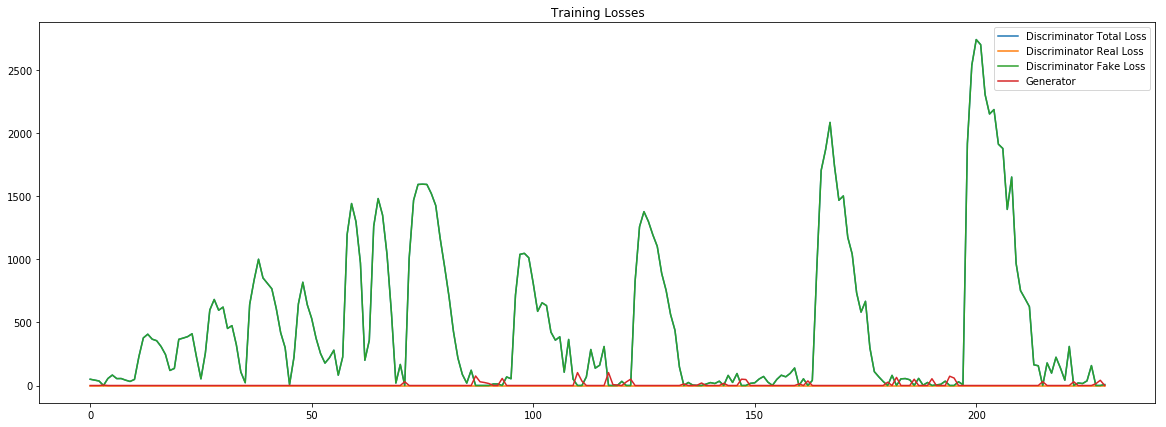

In [13]:
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator Total Loss')
plt.plot(losses.T[1], label='Discriminator Real Loss')
plt.plot(losses.T[2], label='Discriminator Fake Loss')
plt.plot(losses.T[3], label='Generator')
plt.title("Training Losses")
plt.legend()

In [14]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

In [15]:
def view_samples(epoch, samples):
    """
    epoch代表第几次迭代的图像
    samples为我们的采样结果
    """
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][1]): # 这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((56,56)), cmap='Greys_r')
    
    return fig, axes

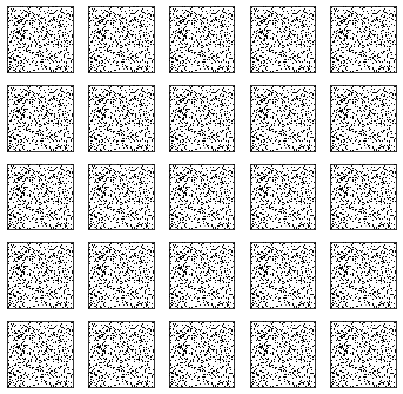

In [16]:
_ = view_samples(-1, samples) # 显示最后一轮的outputs

In [17]:
# 指定要查看的轮次
epoch_idx = [0, 5, 10, 20, 40, 60, 80, 100, 150, 200] # 一共300轮，不要越界
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])

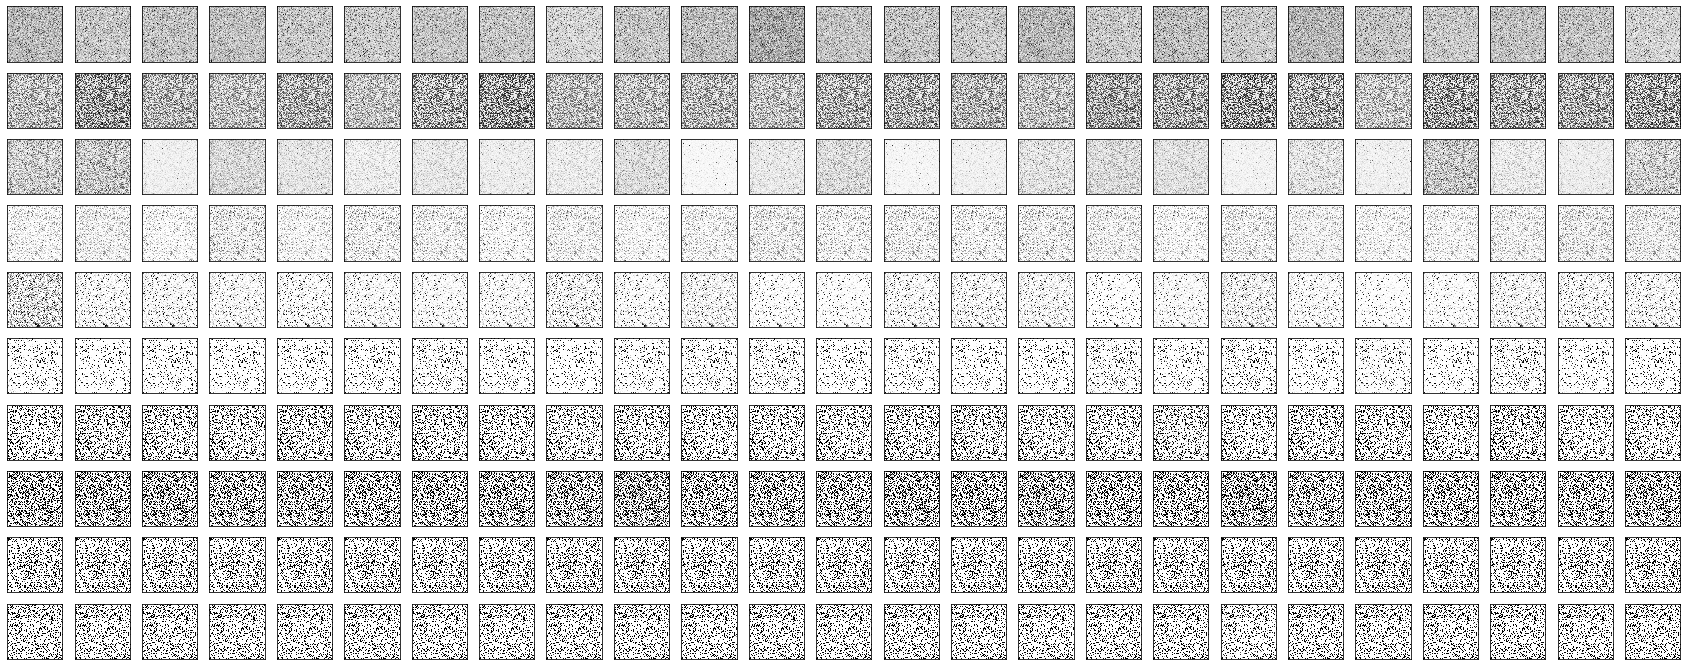

In [19]:
# 指定图片形状
rows, cols = 10, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

idx = range(0, epochs, int(epochs/rows))

for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((56, 56)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [20]:
# 加载我们的生成器变量
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_noise = np.random.uniform(-1, 1, size=(25, noise_size))
    gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                           feed_dict={noise_img: sample_noise})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


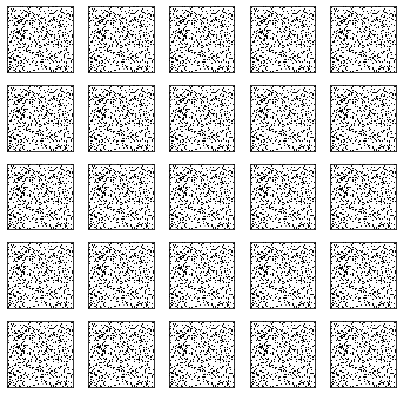

In [21]:
_ = view_samples(0, [gen_samples])